# American Sign Language (ASL) Image Recognition

## Introduction

## Loading in dataset

In [1]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile  
from sklearn.datasets import load_files
from keras.utils import np_utils
from keras.preprocessing import image                  
from tqdm import tqdm

# For compiling model
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D

# For transfer learning
import scipy
import keras.applications.vgg16 as vgg16
import keras.applications.vgg19 as vgg19
import keras.applications.resnet50 as resnet50

# For confusion matrix calculation/visualization
import tensorflow as tf
import seaborn as sn
import pandas as pd

models_dir = 'saved_models'
data_dir = 'data'
bottleneck_feat_dir = 'bottleneck_features'

Using TensorFlow backend.


### Dividing data into training, validation, and testing sets

Now that preprocessing the images is completed (see `data_preprocessing.ipynb` notebook), the full dataset will be split into training, validation, and testing sets. The testing set will be all the images from one subject to mirror the "Spelling It Out" paper's method so the benchmark model can be compared. The rest of the images will be randomly split; 80% of images for training, 20% of the images for validation.

In [2]:
def load_dataset(path, n_categories=24):
    data = load_files(path)
    image_files = np.array(data['filenames'])
    # Hot encode categories to matrix
    image_targets = np_utils.to_categorical(np.array(data['target']), n_categories)
    return image_files, image_targets

def move_data_by_category(container_dir, regex_file_format='.*png'):
    '''Move data into a directory based on category'''
    # Still check if files are images
    file_list = [x for x in os.listdir(container_dir) if re.search(regex_file_format, x)]
    # Get numerical string (note that 1 digits are represented w/ 2 digits) 
    letters = {x.split('_')[0] for x in file_list}
    
    for letter in letters:
        # Only images that match letter
        images_with_letter = [filename for filename in file_list if filename.split('_')[0] == letter]
        # Add images to sub directory
        new_categ_path = os.path.join(container_dir, letter)
        if not os.path.exists(new_categ_path):
            os.makedirs(new_categ_path)
#         print('Created {new_categ_path} dir with {len(images_with_letter)} items')
        for img_filename in images_with_letter:
            path = os.path.join(container_dir, img_filename)
            new_path = os.path.join(new_categ_path, img_filename)            
            os.rename(path, new_path)
    # TODO: Check if any files were skipped (improperly named?)
        

def get_testing_data(data_dir, subject_num='4'):
    '''Get all data/images pertaining to one subject'''
    # Only search in directory for images with that subject
    file_list = [x for x in os.listdir(data_dir) if re.search('\d+_{}_\d*\.png'.format(subject_num), x)]
    
    # Make a new testing data directory if doesn't exist
    testing_dir = os.path.join(data_dir, 'test')
    if not os.path.exists(testing_dir):
        os.makedirs(testing_dir)
        
    # Move images of particular subject into testing directory
    for image_filename in file_list:
        # file is **_n_****.png where n is an integer representing a subject
        _, subject, _ = image_filename.split('_')
        # Move file into testing directory
        path = os.path.join(data_dir, image_filename)
        new_path = os.path.join(testing_dir, image_filename)
        os.rename(path, new_path)
        
    # Move each image file's numerical str representing letters found in testing into own category directory
    move_data_by_category(testing_dir)
    
    return load_dataset(testing_dir)


def get_training_validation_data(data_dir, ratio=0.8):
    '''Randomly split data into training and validation sets'''
    # Only search in directory for images
    file_list = [x for x in os.listdir(data_dir) if re.search('.*png', x)]
    
    # Make a new training & validation data directory if doesn't exist
    train_dir = os.path.join(data_dir, 'train')
    valid_dir = os.path.join(data_dir, 'valid')
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(valid_dir):
        os.makedirs(valid_dir)
        
    # Randomly split file list into training and vaidation sets
    np.random.shuffle(file_list)
    split_int = int(ratio * len(file_list))
    train_list = file_list[:split_int]
    valid_list = file_list[split_int:]
    
    # Move images of particular subject into testing directory
    for filenames, new_dir in [(train_list, train_dir), (valid_list, valid_dir)]:
        for image_filename in filenames:
            # Move file into testing directory
            path = os.path.join(data_dir, image_filename)
            new_path = os.path.join(new_dir, image_filename)
            os.rename(path, new_path)

        # Move each image file's numerical str representing letters found in testing into own category directory
        move_data_by_category(new_dir)
    
    return (load_dataset(train_dir), load_dataset(valid_dir))

In [3]:
# Manually set if the data is RGB
is_rgb = True

test_data, test_targets = get_testing_data(data_dir)
train, valid = get_training_validation_data(data_dir)
# Separated data and its targets
train_data, train_targets = train
valid_data, valid_targets = valid

### Display some of the images

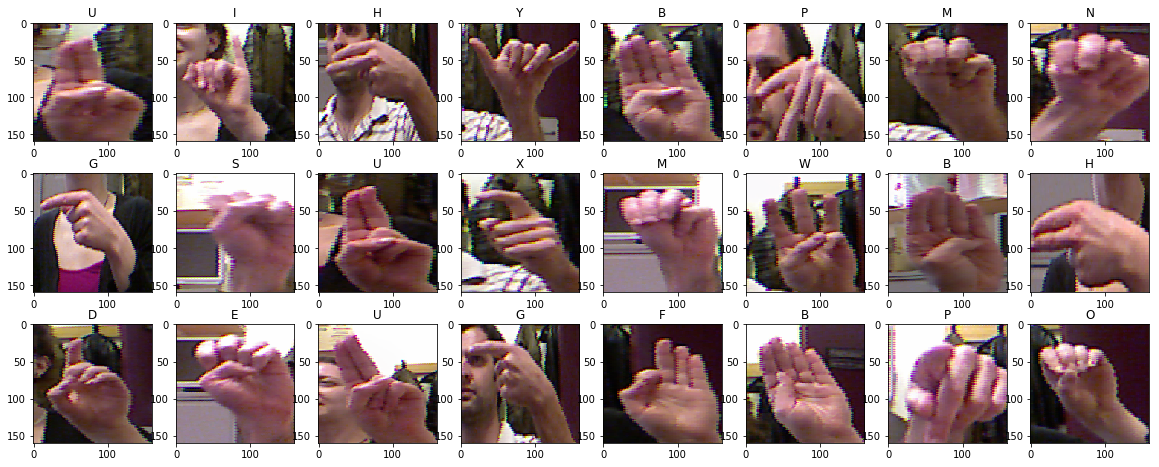

In [27]:
np.random.seed(8675309)
%matplotlib inline

# Display image previews below
plt.figure(figsize=(20,55))
columns = 8
n = 1

# Randomly choose images to display (with label)
for image_path in np.random.choice(train_data, 24, replace=False):
    img = Image.open(image_path)
    plt.subplot(20, columns, n)
    n+=1
    plt.imshow(img)
    letter = image_path.split('/')[-1][:2]
    letter = chr(int(letter)+65)
    plt.title(letter)

### Preparing the model

In [ ]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (224, 224, 1)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 1) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
valid_tensors = paths_to_tensor(valid_data).astype('float32')
test_tensors = paths_to_tensor(test_data).astype('float32')

In [ ]:
# Prepare training data separately since this is usually large
train_tensors = paths_to_tensor(train_data).astype('float32')

## Basic CNN model from scratch

### Building basic model

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
#Convo 224, 224, 1
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 1)))
#
model.add(MaxPooling2D(pool_size=2))
#
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
#
model.add(MaxPooling2D(pool_size=2))
#
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
#
model.add(MaxPooling2D(pool_size=2))
#
model.add(GlobalAveragePooling2D())
#Dense; 24 for each handshape 
model.add(Dense(24, activation='softmax'))


model.summary()

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Training basic model

In [ ]:
from keras.callbacks import ModelCheckpoint  

epochs = 16

# Create a saved models directory
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath=f'{models_dir}/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

### Evaluating basic model

In [ ]:
handshape_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(handshape_predictions)==np.argmax(test_targets, axis=1))/len(handshape_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

## Transfer Learning with VGG16

### Preparing the model

In [ ]:
# Define image size to use for given model
n_pixels = 80
# Define a model name for records
model_name ='rgbModel_{}px'.format(n_pixels) if is_rgb else 'model_{}px'.format(n_pixels)

In [ ]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(n_pixels, n_pixels), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (n, n, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, n, n, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# Pre-process the data for Keras
# Prepare training data separately since this is usually large

print('Preparing to create valid tensors')
valid_tensors = paths_to_tensor(valid_data).astype('float32')
print('valid tensors prepared')

In [ ]:
print('Preparing to create test tensors')
test_tensors = paths_to_tensor(test_data).astype('float32')
print('test tensors prepared')

In [ ]:
print('Preparing to create train tensors')
train_tensors = paths_to_tensor(train_data).astype('float32')
print('train tensors prepared')

### Extract Bottleneck Features for Training Set

In [ ]:
# Name & path of bottleneck features
feat_train_name = 'vgg16_{}_features_train'.format(model_name)
feat_train_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_train_name)

# Load the data
targets = np.squeeze(train_targets)
print('data loaded')

# Load vgg16 model + remove final classification layers
model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(n_pixels, n_pixels, 3), classes=24)
print('model loaded')

# Obtain bottleneck features (train)
if os.path.exists(feat_train_path):
    print('bottleneck features detected (train)')
    features = np.load(feat_train_path)['features']
else:
    print('bottleneck features file not detected (train)')
    
    print('calculating now ...')
    # Pre-process the train data
    big_x_train = np.array([scipy.misc.imresize(train_tensors[i], (n_pixels, n_pixels, 3)) 
                            for i in range(0, len(train_tensors))]).astype('float32')
    vgg16_input_train = vgg16.preprocess_input(big_x_train)
    print('train data preprocessed')
    
    # Extract, process, and save bottleneck features
    features = model.predict(vgg16_input_train)
    features = np.squeeze(features)
    np.savez(feat_train_path, features=features)

print('bottleneck features saved (train)')

### Extract Bottleneck Features for Validation Set

In [ ]:
# Name & path of bottleneck features
feat_valid_name = 'vgg16_{}_features_valid'.format(model_name)
feat_valid_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_valid_name)

# Obtain bottleneck features (valid)
if os.path.exists(feat_valid_path):
    print('bottleneck features detected (valid)')
    features_valid = np.load(feat_valid_path)['features_test']
else:
    # Calculating for validation set
    print('bottleneck features file not detected (valid)')
    print('calculating now ...')
    # Pre-process the valid data
    big_x_valid = np.array([scipy.misc.imresize(valid_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(valid_tensors))]).astype('float32')

    vgg16_input_valid = vgg16.preprocess_input(big_x_valid)
    # Extract, process, and save bottleneck features (valid)
    features_valid = model.predict(vgg16_input_valid)
    features_valid = np.squeeze(features_valid)
    np.savez(feat_valid_path, features_test=features_valid)
print('bottleneck features saved (valid)')

### Extract Bottleneck Features for Test Set

In [ ]:
# Name & path of bottleneck features
feat_test_name = 'vgg16_{}_features_test'.format(model_name)
feat_test_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_test_name)

# Obtain bottleneck features (test)
if os.path.exists(feat_test_path):
    print('bottleneck features detected (test)')
    features_test = np.load(feat_test_path)['features_test']
else:
    # Calculating for test set
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_x_test = np.array([scipy.misc.imresize(test_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(test_tensors))]).astype('float32')

    vgg16_input_test = vgg16.preprocess_input(big_x_test)
    # Extract, process, and save bottleneck features (test)
    features_test = model.predict(vgg16_input_test)
    features_test = np.squeeze(features_test)
    np.savez(feat_test_path, features_test=features_test)
print('bottleneck features saved (test)')

### Building model

In [ ]:
features.shape
type(features)
features_ = features

In [ ]:
# 3 CNN Layers
model = Sequential()

model.add(Conv2D(filters=256, kernel_size=2, input_shape=features.shape[1:]))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128, kernel_size=1))

model.add(Conv2D(filters=32, kernel_size=1))
model.add(Dropout(0.3))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

model.add(Dense(24, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
epochs = 50
batchsize = 500
model_weights_path = '{}/vgg16_{}.best_batch{}_epoch{}.hdf5'.format(models_dir,model_name,batchsize,epochs)

checkpointer = ModelCheckpoint(filepath=model_weights_path, 
                               verbose=1, save_best_only=True)

model.fit(features, targets, batch_size=batchsize, epochs=epochs,
          validation_data=(features_valid, valid_targets),
          callbacks=[checkpointer],
          verbose=2, shuffle=True)          

### Evaluating the model

In [ ]:
# Load the weights that yielded the best validation accuracy
model.load_weights(model_weights_path)

# Evaluate test accuracy
score = model.evaluate(features_test, test_targets, verbose=0)
accuracy = 100*score[1]

# Print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

## Transfer Learning with VGG19

### Preparing the model

In [ ]:
# Define image size to use for given model
n_pixels = 160
# Define a model name for recorcs
model_name = 'model_{}px'.format(n_pixels)

In [ ]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(n_pixels, n_pixels), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (n, n, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, n, n, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# Pre-process the data for Keras
# Prepare training data separately since this is usually large

print('Preparing to create valid tensors')
valid_tensors = paths_to_tensor(valid_data).astype('float32')
print('valid tensors prepared')

In [ ]:
print('Preparing to create test tensors')
test_tensors = paths_to_tensor(test_data).astype('float32')
print('test tensors prepared')

In [ ]:
print('Preparing to create train tensors')
train_tensors = paths_to_tensor(train_data).astype('float32')
print('train tensors prepared')

### Extract Bottleneck Features for Training Set

In [ ]:
# Load the data
targets = np.squeeze(train_targets)
print('data loaded')

# Load vgg19 model + remove final classification layers
model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(n_pixels, n_pixels, 3), classes=24)
print('model loaded')

# Obtain bottleneck features (train)
if os.path.exists('vgg19_features_train.npz'):
    print('bottleneck features detected (train)')
    features = np.load('vgg19_features_train.npz')['features']
else:
    print('bottleneck features file not detected (train)')
    
    print('calculating now ...')
    # Pre-process the train data
    big_x_train = np.array([scipy.misc.imresize(train_tensors[i], (n_pixels, n_pixels, 3)) 
                            for i in range(0, len(train_tensors))]).astype('float32')
    vgg19_input_train = vgg19.preprocess_input(big_x_train)
    print('train data preprocessed')
    
    # Extract, process, and save bottleneck features
    features = model.predict(vgg19_input_train)
    features = np.squeeze(features)
    np.savez('vgg19_features_train', features=features)

print('bottleneck features saved (train)')

### Extract Bottleneck Features for Validation Set

In [ ]:
# Obtain bottleneck features (valid)
if os.path.exists('vgg19_features_valid.npz'):
    print('bottleneck features detected (valid)')
    features_valid = np.load('vgg19_features_valid.npz')['features_test']
else:
    # Calculating for validation set
    print('bottleneck features file not detected (valid)')
    print('calculating now ...')
    # Pre-process the valid data
    big_x_valid = np.array([scipy.misc.imresize(valid_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(valid_tensors))]).astype('float32')

    vgg19_input_valid = vgg19.preprocess_input(big_x_valid)
    # Extract, process, and save bottleneck features (valid)
    features_valid = model.predict(vgg19_input_valid)
    features_valid = np.squeeze(features_valid)
    np.savez('vgg19_features_valid', features_test=features_valid)
print('bottleneck features saved (valid)')

### Extract Bottleneck Features for Test Set

In [ ]:
# Obtain bottleneck features (test)
if os.path.exists('vgg19_features_test.npz'):
    print('bottleneck features detected (test)')
    features_test = np.load('vgg19_features_test.npz')['features_test']
else:
    # Calculating for test set
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_x_test = np.array([scipy.misc.imresize(test_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(test_tensors))]).astype('float32')

    vgg19_input_test = vgg19.preprocess_input(big_x_test)
    # Extract, process, and save bottleneck features (test)
    features_test = model.predict(vgg19_input_test)
    features_test = np.squeeze(features_test)
    np.savez('vgg19_features_test', features_test=features_test)
print('bottleneck features saved (test)')

### Building model

In [ ]:
features.shape

In [ ]:
# Shallow NN
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(filters=256, kernel_size=2, input_shape=features.shape[1:]))
model.add(Dropout(0.4))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(24, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])



In [ ]:
epochs = 256
batchsize = 512
model_weights_path = f'{models_dir}/vgg19_new_{model_name}.best_batch{batchsize}_epoch{epochs}.hdf5'

checkpointer = ModelCheckpoint(filepath=model_weights_path, 
                               verbose=1, save_best_only=True)

model.fit(features, targets, batch_size=batchsize, epochs=epochs,
          validation_data=(features_valid, valid_targets),
          callbacks=[checkpointer],
          verbose=2, shuffle=True)          

### Evaluating the model

In [ ]:
# Load the weights that yielded the best validation accuracy
model.load_weights(model_weights_path)

# Evaluate test accuracy
score = model.evaluate(features_test, test_targets, verbose=0)
accuracy = 100*score[1]

# Print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

## Transfer Learning with ResNet50

### Preparing the model

In [4]:
# Define image size to use for given model
n_pixels = 197
# Define a model name for records
model_name ='rgbModel_{}px'.format(n_pixels) if is_rgb else 'model_{}px'.format(n_pixels)

In [5]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(n_pixels, n_pixels), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (n, n, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, n, n, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [8]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# Pre-process the data for Keras
# Prepare training data separately since this is usually large

print('Preparing to create valid tensors')
valid_tensors = paths_to_tensor(valid_data).astype('float32')
print('valid tensors prepared')

  1%|          | 69/10599 [00:00<00:15, 686.63it/s]

Preparing to create valid tensors


100%|██████████| 10599/10599 [00:16<00:00, 658.26it/s]


valid tensors prepared


In [13]:
print('Preparing to create test tensors')
test_tensors = paths_to_tensor(test_data).astype('float32')
print('test tensors prepared')

  0%|          | 58/12782 [00:00<00:22, 577.28it/s]

Preparing to create test tensors


100%|██████████| 12782/12782 [00:21<00:00, 594.40it/s]


test tensors prepared


In [12]:
print('Preparing to create train tensors')
train_tensors = paths_to_tensor(train_data).astype('float32')
print('train tensors prepared')

Preparing to create train tensors
train tensors prepared


### Extract Bottleneck Features for Training Set

In [7]:
# Name & path of bottleneck features
feat_train_name = 'resnet50_{}_features_train'.format(model_name)
feat_train_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_train_name)

# Load the data
targets = np.squeeze(train_targets)
print('data loaded')

# Load resnet50 model + remove final classification layers
model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(n_pixels, n_pixels, 3), classes=24)
print('model loaded')

# Obtain bottleneck features (train)
if os.path.exists(feat_train_path):
    print('bottleneck features detected (train)')
    features = np.load(feat_train_path)['features']
else:
    print('bottleneck features file not detected (train)')
    
    print('calculating now ...')
    # Pre-process the train data
    big_x_train = np.array([scipy.misc.imresize(train_tensors[i], (n_pixels, n_pixels, 3)) 
                            for i in range(0, len(train_tensors))]).astype('float32')
    resnet50_input_train = resnet50.preprocess_input(big_x_train)
    print('train data preprocessed')
    
    # Extract, process, and save bottleneck features
    features = model.predict(resnet50_input_train)
#     features = np.squeeze(features)
    np.savez(feat_train_path, features=features)

print('bottleneck features saved (train)')

data loaded
model loaded
bottleneck features file not detected (train)
calculating now ...
train data preprocessed
bottleneck features saved (train)


### Extract Bottleneck Features for Validation Set

In [9]:
# Name & path of bottleneck features
feat_valid_name = 'resnet50_{}_features_valid'.format(model_name)
feat_valid_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_valid_name)

# Obtain bottleneck features (valid)
if os.path.exists(feat_valid_path):
    print('bottleneck features detected (valid)')
    features_valid = np.load(feat_valid_path)['features_test']
else:
    # Calculating for validation set
    print('bottleneck features file not detected (valid)')
    print('calculating now ...')
    # Pre-process the valid data
    big_x_valid = np.array([scipy.misc.imresize(valid_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(valid_tensors))]).astype('float32')

    resnet50_input_valid = resnet50.preprocess_input(big_x_valid)
    # Extract, process, and save bottleneck features (valid)
    features_valid = model.predict(resnet50_input_valid)
#     features_valid = np.squeeze(features_valid)
    np.savez(feat_valid_path, features_test=features_valid)
print('bottleneck features saved (valid)')

bottleneck features file not detected (valid)
calculating now ...
bottleneck features saved (valid)


### Extract Bottleneck Features for Test Set

In [14]:
# Name & path of bottleneck features
feat_test_name = 'resnet50_{}_features_test'.format(model_name)
feat_test_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_test_name)

# Obtain bottleneck features (test)
if os.path.exists(feat_test_path):
    print('bottleneck features detected (test)')
    features_test = np.load(feat_test_path)['features_test']
else:
    # Calculating for test set
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_x_test = np.array([scipy.misc.imresize(test_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(test_tensors))]).astype('float32')

    resnet50_input_test = resnet50.preprocess_input(big_x_test)
    # Extract, process, and save bottleneck features (test)
    features_test = model.predict(resnet50_input_test)
#     features_test = np.squeeze(features_test)
    np.savez(feat_test_path, features_test=features_test)
print('bottleneck features saved (test)')

bottleneck features file not detected (test)
calculating now ...
bottleneck features saved (test)


### Building model

In [16]:
# 3 CNN Layers
model = Sequential()

model.add(Conv2D(filters=256, kernel_size=1, input_shape=features.shape[1:]))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128, kernel_size=1))

model.add(Conv2D(filters=32, kernel_size=1))
model.add(Dropout(0.3))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

model.add(Dense(24, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 1, 256)         524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 128)         32896     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 32)          4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
__________

In [29]:
epochs = 550
batchsize = 2048
model_details = 'resnet50_{}_batch{}_epoch{}'.format(model_name,batchsize,epochs)
model_weights_path = '{}/{}.hdf5'.format(models_dir,model_details)

checkpointer = ModelCheckpoint(filepath=model_weights_path, 
                               verbose=1, save_best_only=True)

model.fit(features, targets, batch_size=batchsize, epochs=epochs,
          validation_data=(features_valid, valid_targets),
          callbacks=[checkpointer],
          verbose=2, shuffle=True)          

Train on 42393 samples, validate on 10599 samples
Epoch 1/550
Epoch 00000: val_loss improved from inf to 0.13522, saving model to saved_models/vgg16_rgbModel_197px.best_batch2048_epoch550.hdf5
0s - loss: 0.3069 - acc: 0.8993 - val_loss: 0.1352 - val_acc: 0.9591
Epoch 2/550
Epoch 00001: val_loss improved from 0.13522 to 0.11175, saving model to saved_models/vgg16_rgbModel_197px.best_batch2048_epoch550.hdf5
0s - loss: 0.3503 - acc: 0.8898 - val_loss: 0.1117 - val_acc: 0.9653
Epoch 3/550
Epoch 00002: val_loss did not improve
0s - loss: 0.3058 - acc: 0.8964 - val_loss: 0.1819 - val_acc: 0.9411
Epoch 4/550
Epoch 00003: val_loss did not improve
0s - loss: 0.2987 - acc: 0.8996 - val_loss: 0.1763 - val_acc: 0.9399
Epoch 5/550
Epoch 00004: val_loss did not improve
0s - loss: 0.2969 - acc: 0.9004 - val_loss: 0.1477 - val_acc: 0.9516
Epoch 6/550
Epoch 00005: val_loss did not improve
0s - loss: 0.3037 - acc: 0.8967 - val_loss: 0.2432 - val_acc: 0.9204
Epoch 7/550
Epoch 00006: val_loss did not impr

Epoch 00064: val_loss did not improve
0s - loss: 0.2222 - acc: 0.9241 - val_loss: 0.0939 - val_acc: 0.9693
Epoch 66/550
Epoch 00065: val_loss did not improve
0s - loss: 0.2453 - acc: 0.9219 - val_loss: 0.0932 - val_acc: 0.9687
Epoch 67/550
Epoch 00066: val_loss did not improve
0s - loss: 0.2483 - acc: 0.9152 - val_loss: 0.0941 - val_acc: 0.9708
Epoch 68/550
Epoch 00067: val_loss did not improve
0s - loss: 0.2646 - acc: 0.9121 - val_loss: 0.0837 - val_acc: 0.9732
Epoch 69/550
Epoch 00068: val_loss did not improve
0s - loss: 0.2375 - acc: 0.9203 - val_loss: 0.1215 - val_acc: 0.9568
Epoch 70/550
Epoch 00069: val_loss did not improve
0s - loss: 0.2373 - acc: 0.9205 - val_loss: 0.0912 - val_acc: 0.9709
Epoch 71/550
Epoch 00070: val_loss did not improve
0s - loss: 0.2239 - acc: 0.9237 - val_loss: 0.1088 - val_acc: 0.9662
Epoch 72/550
Epoch 00071: val_loss did not improve
0s - loss: 0.2338 - acc: 0.9197 - val_loss: 0.1378 - val_acc: 0.9531
Epoch 73/550
Epoch 00072: val_loss did not improve
0s

Epoch 00128: val_loss did not improve
0s - loss: 0.2205 - acc: 0.9278 - val_loss: 0.0634 - val_acc: 0.9812
Epoch 130/550
Epoch 00129: val_loss did not improve
0s - loss: 0.2035 - acc: 0.9331 - val_loss: 0.0850 - val_acc: 0.9711
Epoch 131/550
Epoch 00130: val_loss did not improve
0s - loss: 0.1990 - acc: 0.9323 - val_loss: 0.0745 - val_acc: 0.9755
Epoch 132/550
Epoch 00131: val_loss did not improve
0s - loss: 0.2178 - acc: 0.9283 - val_loss: 0.1207 - val_acc: 0.9572
Epoch 133/550
Epoch 00132: val_loss did not improve
0s - loss: 0.1860 - acc: 0.9362 - val_loss: 0.1175 - val_acc: 0.9612
Epoch 134/550
Epoch 00133: val_loss did not improve
0s - loss: 0.2228 - acc: 0.9284 - val_loss: 0.0879 - val_acc: 0.9743
Epoch 135/550
Epoch 00134: val_loss did not improve
0s - loss: 0.2241 - acc: 0.9240 - val_loss: 0.0889 - val_acc: 0.9700
Epoch 136/550
Epoch 00135: val_loss did not improve
0s - loss: 0.1888 - acc: 0.9365 - val_loss: 0.0623 - val_acc: 0.9806
Epoch 137/550
Epoch 00136: val_loss improved f

Epoch 00194: val_loss did not improve
0s - loss: 0.1760 - acc: 0.9403 - val_loss: 0.1750 - val_acc: 0.9436
Epoch 196/550
Epoch 00195: val_loss did not improve
0s - loss: 0.2030 - acc: 0.9340 - val_loss: 0.0668 - val_acc: 0.9782
Epoch 197/550
Epoch 00196: val_loss did not improve
0s - loss: 0.1664 - acc: 0.9450 - val_loss: 0.0570 - val_acc: 0.9815
Epoch 198/550
Epoch 00197: val_loss did not improve
0s - loss: 0.1717 - acc: 0.9414 - val_loss: 0.1259 - val_acc: 0.9598
Epoch 199/550
Epoch 00198: val_loss did not improve
0s - loss: 0.1834 - acc: 0.9374 - val_loss: 0.0614 - val_acc: 0.9810
Epoch 200/550
Epoch 00199: val_loss did not improve
0s - loss: 0.1985 - acc: 0.9349 - val_loss: 0.0844 - val_acc: 0.9715
Epoch 201/550
Epoch 00200: val_loss did not improve
0s - loss: 0.1650 - acc: 0.9443 - val_loss: 0.0777 - val_acc: 0.9726
Epoch 202/550
Epoch 00201: val_loss did not improve
0s - loss: 0.1717 - acc: 0.9433 - val_loss: 0.1118 - val_acc: 0.9631
Epoch 203/550
Epoch 00202: val_loss did not im

Epoch 00261: val_loss did not improve
0s - loss: 0.1735 - acc: 0.9420 - val_loss: 0.0569 - val_acc: 0.9825
Epoch 263/550
Epoch 00262: val_loss did not improve
0s - loss: 0.1350 - acc: 0.9532 - val_loss: 0.0714 - val_acc: 0.9759
Epoch 264/550
Epoch 00263: val_loss did not improve
0s - loss: 0.1607 - acc: 0.9453 - val_loss: 0.1134 - val_acc: 0.9653
Epoch 265/550
Epoch 00264: val_loss did not improve
0s - loss: 0.1731 - acc: 0.9427 - val_loss: 0.1220 - val_acc: 0.9607
Epoch 266/550
Epoch 00265: val_loss did not improve
0s - loss: 0.1635 - acc: 0.9435 - val_loss: 0.0700 - val_acc: 0.9770
Epoch 267/550
Epoch 00266: val_loss did not improve
0s - loss: 0.1586 - acc: 0.9475 - val_loss: 0.0625 - val_acc: 0.9804
Epoch 268/550
Epoch 00267: val_loss did not improve
0s - loss: 0.1710 - acc: 0.9424 - val_loss: 0.0587 - val_acc: 0.9806
Epoch 269/550
Epoch 00268: val_loss did not improve
0s - loss: 0.1296 - acc: 0.9549 - val_loss: 0.0585 - val_acc: 0.9811
Epoch 270/550
Epoch 00269: val_loss did not im

Epoch 00328: val_loss did not improve
0s - loss: 0.1368 - acc: 0.9531 - val_loss: 0.0638 - val_acc: 0.9791
Epoch 330/550
Epoch 00329: val_loss did not improve
0s - loss: 0.1636 - acc: 0.9479 - val_loss: 0.0834 - val_acc: 0.9729
Epoch 331/550
Epoch 00330: val_loss did not improve
0s - loss: 0.1427 - acc: 0.9501 - val_loss: 0.0933 - val_acc: 0.9708
Epoch 332/550
Epoch 00331: val_loss did not improve
0s - loss: 0.1627 - acc: 0.9466 - val_loss: 0.1094 - val_acc: 0.9666
Epoch 333/550
Epoch 00332: val_loss did not improve
0s - loss: 0.1494 - acc: 0.9509 - val_loss: 0.1121 - val_acc: 0.9656
Epoch 334/550
Epoch 00333: val_loss did not improve
0s - loss: 0.1229 - acc: 0.9590 - val_loss: 0.0982 - val_acc: 0.9683
Epoch 335/550
Epoch 00334: val_loss did not improve
0s - loss: 0.1474 - acc: 0.9501 - val_loss: 0.0646 - val_acc: 0.9800
Epoch 336/550
Epoch 00335: val_loss did not improve
0s - loss: 0.1487 - acc: 0.9486 - val_loss: 0.0478 - val_acc: 0.9853
Epoch 337/550
Epoch 00336: val_loss did not im

Epoch 00395: val_loss did not improve
0s - loss: 0.1422 - acc: 0.9524 - val_loss: 0.0849 - val_acc: 0.9736
Epoch 397/550
Epoch 00396: val_loss did not improve
0s - loss: 0.1229 - acc: 0.9587 - val_loss: 0.0499 - val_acc: 0.9841
Epoch 398/550
Epoch 00397: val_loss did not improve
0s - loss: 0.1236 - acc: 0.9559 - val_loss: 0.0898 - val_acc: 0.9697
Epoch 399/550
Epoch 00398: val_loss did not improve
0s - loss: 0.1396 - acc: 0.9536 - val_loss: 0.2201 - val_acc: 0.9388
Epoch 400/550
Epoch 00399: val_loss did not improve
0s - loss: 0.1369 - acc: 0.9563 - val_loss: 0.1045 - val_acc: 0.9662
Epoch 401/550
Epoch 00400: val_loss did not improve
0s - loss: 0.1445 - acc: 0.9502 - val_loss: 0.0777 - val_acc: 0.9751
Epoch 402/550
Epoch 00401: val_loss did not improve
0s - loss: 0.1284 - acc: 0.9546 - val_loss: 0.0495 - val_acc: 0.9843
Epoch 403/550
Epoch 00402: val_loss did not improve
0s - loss: 0.1352 - acc: 0.9532 - val_loss: 0.0485 - val_acc: 0.9847
Epoch 404/550
Epoch 00403: val_loss did not im

Epoch 00462: val_loss did not improve
0s - loss: 0.1293 - acc: 0.9569 - val_loss: 0.0468 - val_acc: 0.9847
Epoch 464/550
Epoch 00463: val_loss improved from 0.04476 to 0.04415, saving model to saved_models/vgg16_rgbModel_197px.best_batch2048_epoch550.hdf5
0s - loss: 0.1246 - acc: 0.9598 - val_loss: 0.0441 - val_acc: 0.9864
Epoch 465/550
Epoch 00464: val_loss did not improve
0s - loss: 0.1128 - acc: 0.9610 - val_loss: 0.0777 - val_acc: 0.9758
Epoch 466/550
Epoch 00465: val_loss did not improve
0s - loss: 0.1235 - acc: 0.9577 - val_loss: 0.0707 - val_acc: 0.9787
Epoch 467/550
Epoch 00466: val_loss did not improve
0s - loss: 0.1317 - acc: 0.9536 - val_loss: 0.0674 - val_acc: 0.9789
Epoch 468/550
Epoch 00467: val_loss did not improve
0s - loss: 0.1341 - acc: 0.9546 - val_loss: 0.0477 - val_acc: 0.9853
Epoch 469/550
Epoch 00468: val_loss did not improve
0s - loss: 0.1273 - acc: 0.9565 - val_loss: 0.0667 - val_acc: 0.9791
Epoch 470/550
Epoch 00469: val_loss did not improve
0s - loss: 0.1275 

Epoch 00529: val_loss did not improve
0s - loss: 0.1045 - acc: 0.9646 - val_loss: 0.0817 - val_acc: 0.9725
Epoch 531/550
Epoch 00530: val_loss did not improve
0s - loss: 0.1162 - acc: 0.9599 - val_loss: 0.0484 - val_acc: 0.9848
Epoch 532/550
Epoch 00531: val_loss did not improve
0s - loss: 0.1251 - acc: 0.9568 - val_loss: 0.0645 - val_acc: 0.9790
Epoch 533/550
Epoch 00532: val_loss did not improve
0s - loss: 0.1194 - acc: 0.9598 - val_loss: 0.0499 - val_acc: 0.9841
Epoch 534/550
Epoch 00533: val_loss did not improve
0s - loss: 0.1037 - acc: 0.9635 - val_loss: 0.0628 - val_acc: 0.9802
Epoch 535/550
Epoch 00534: val_loss did not improve
0s - loss: 0.1179 - acc: 0.9607 - val_loss: 0.0589 - val_acc: 0.9808
Epoch 536/550
Epoch 00535: val_loss did not improve
0s - loss: 0.1277 - acc: 0.9559 - val_loss: 0.1383 - val_acc: 0.9594
Epoch 537/550
Epoch 00536: val_loss did not improve
0s - loss: 0.1028 - acc: 0.9654 - val_loss: 0.0750 - val_acc: 0.9786
Epoch 538/550
Epoch 00537: val_loss did not im

### Evaluating the model

In [30]:
# Load the weights that yielded the best validation accuracy
model.load_weights(model_weights_path)

# Evaluate test accuracy
score = model.evaluate(features_test, test_targets, verbose=0)
accuracy = 100*score[1]

# Print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 70.3176%


## Confusion Matrix of Test Data

After performing tests, a confusion matrix can be used to evaluate the model and it's accuracy for each ASL handshape/letter. Below we use the weight's from the last model defined and used above to generate our confusion matrix.

In [31]:
# Load the weights of 
# model_weights_path = 'saved_models/vgg16_rgbModel_100px.best_batch500_epoch150.hdf5'
model.load_weights(model_weights_path)

test_predictions = model.predict_classes(features_test)

12192/12782 [===========================>..] - ETA: 0s

In [32]:
sess = tf.Session()
# Change one-hot encoding to just an integer representing letter
un_hot_encode_targets = np.argmax(test_targets, axis=1)

confusion_arr = sess.run(tf.confusion_matrix(un_hot_encode_targets, test_predictions, 24))
# Get percents to compare with research paper benchmark
confusion_arr_percents = confusion_arr/sum(confusion_arr)

In [22]:
# Note no 'J' & 'Z' were used
letters = "ABCDEFGHIKLMNOPQRSTUVWXY"

# Print out counts to see distribution of the number of letters tested against
for elem in ['{}: {}'.format(letter,count) for letter,count in zip(letters,sum(confusion_arr))]:
    print(elem)

A: 488
B: 568
C: 498
D: 389
E: 826
F: 480
G: 867
H: 131
I: 334
K: 658
L: 568
M: 447
N: 1402
O: 452
P: 312
Q: 302
R: 708
S: 303
T: 366
U: 746
V: 714
W: 504
X: 270
Y: 449


In [33]:
# Save confusion matrix/array as CSVs for reference
np.savetxt('confusion_matrices/confusionMatrix_{}_counts.csv'.format(model_details),confusion_arr)
np.savetxt('confusion_matrices/confusionMatrix_{}_percent.csv'.format(model_details),confusion_arr_percents)

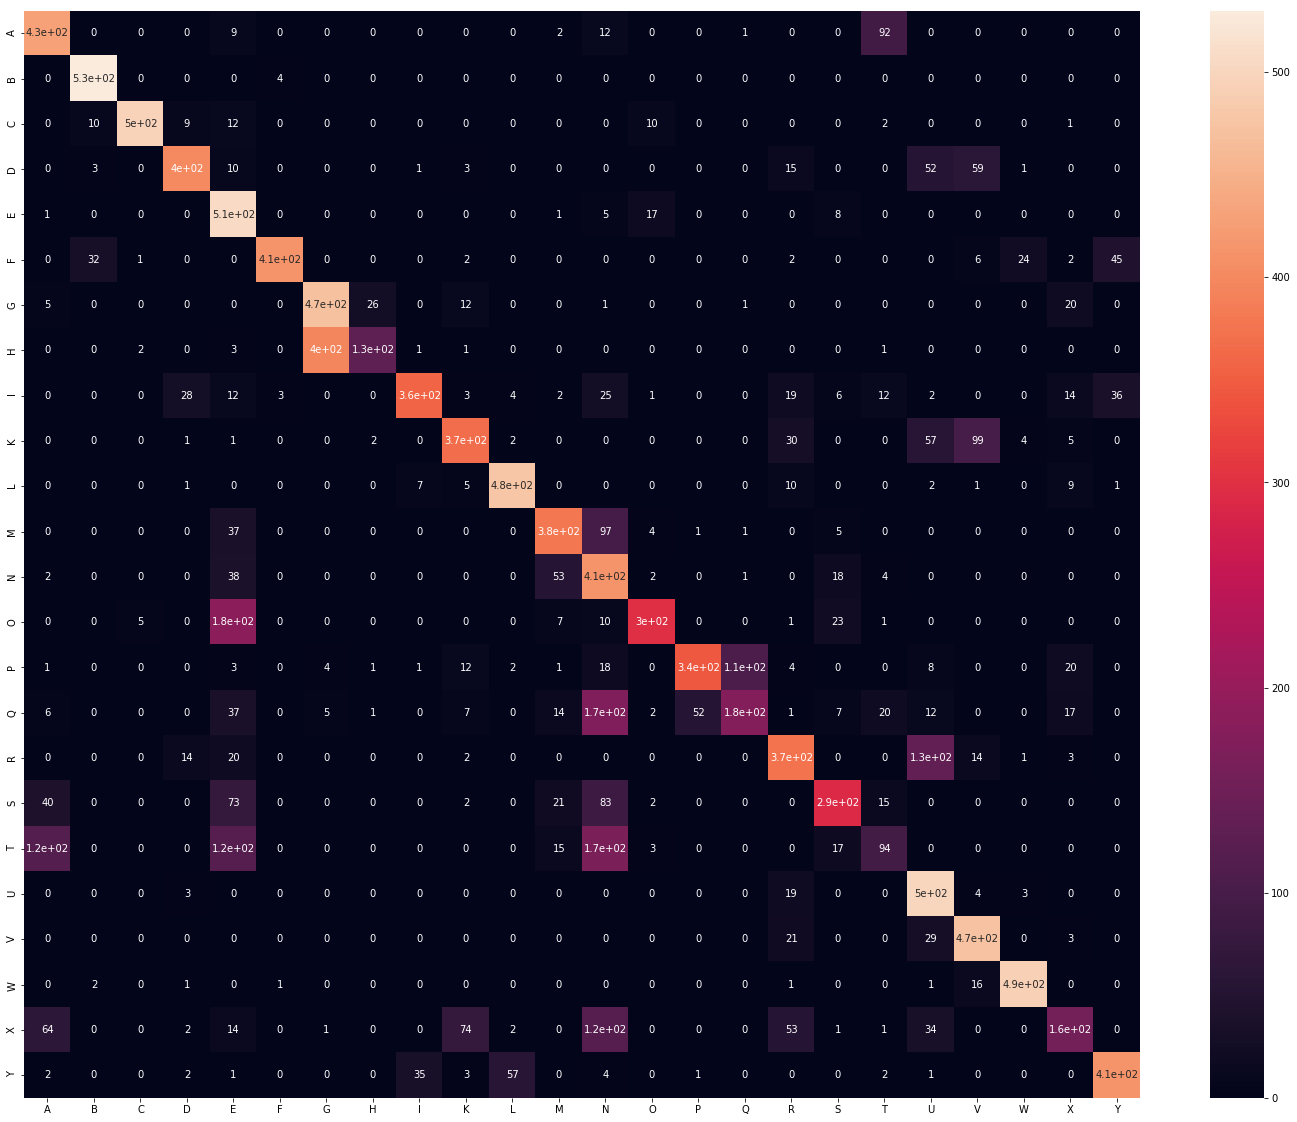

In [34]:
df_cm = pd.DataFrame(confusion_arr, index = [i for i in letters],
                  columns = [i for i in letters])
plt.figure(figsize = (25,20))
sn.heatmap(df_cm, annot=True)

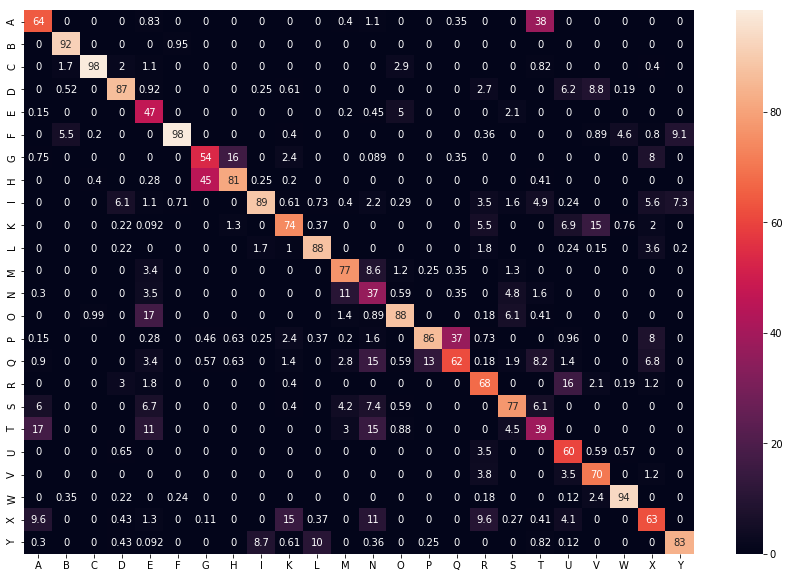

In [35]:
# Percentages for confusion matrix
# Multiplied by 100 to make it easier to read values
df_cm = pd.DataFrame(confusion_arr_percents*100, index = [i for i in letters],
                  columns = [i for i in letters])
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True)